* **Author**: Andrea Ziqing Gallardo Bendito

* **Project**: Bachelor Thesis - *Separación de fuentes musicales en conjuntos de cámara de música clásica*

* **GitHub Repo**: [MusicSourceSep](https://github.com/andrezg98/MusicSourceSep)

In this Notebook we are going to generate training data for music source separation *on the fly* using the [Scaper python library](https://github.com/justinsalamon/scaper) based on this [tutorial](https://source-separation.github.io/tutorial/data/scaper.html#generating-data) and train the ***Mask Inference* model** implemented by the [Nussl](https://nussl.github.io/docs/) library created by [Interactive Audio Lab](https://interactiveaudiolab.github.io/).



---



## **Project repository download and Library installations**

In [83]:
!pip install scaper -q
!pip install nussl -q
!pip install git+https://github.com/source-separation/tutorial -q

### **Imports**

In [2]:
# To keep things clean we'll hide all warnings
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Imports
import numpy as np
import librosa
import torch
import pandas as pd
import os
import glob
from scipy.io.wavfile import write
from IPython.display import Audio, display
from google.colab import files
from pathlib import Path
import shutil
import json
import matplotlib.pyplot as plt

# Scaper
import scaper

# Nussl
import nussl
from nussl.datasets import transforms as nussl_tfm
from nussl.datasets import hooks
from common.models import MaskInference
from common import utils, data
from common import viz

## **Dataset Downloads**

* **Bach10 Dataset**
  
    Accessing the dataset stored in my Google Drive:

In [4]:
%cd /content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Datasets

/content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Datasets


> **Note**: To download the dataset for the first time, you can access [here](https://https://docs.google.com/forms/d/e/1FAIpQLSfJ1IdB7Ws2_m0wkkvS1hGm5GevGS3QmqBIoxiGDbw93yoPLQ/viewform?embedded=true&formkey=dGU3cmRlb1Q4RU5zTGNZeHUyRGFwaWc6MQ). The authors ask you to fill in a short form in order to keep track of the use of the dataset. Once downloaded, you can easily unzip and access it as follows. The dataset will be saved in the path you have specified.

In [ ]:
# !unzip bach10_dataset_compressed.zip



---



##  **Prepare the source material for the model**

First, a *Bach10_nussl* folder has been created which will contain our original Bach10 dataset sorted and organized in several folders (one for each song) in order to make the ***leave-one-out*** process easier in the training and evaluation of the model.

> **Note**: We will only have to execute these cells once to create the corresponding folders.

In [ ]:
%cd Bach10_nussl/

/content/drive/MyDrive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl


In [ ]:
tr_val_test = ['train', 'valid', 'test']
sources = ['bassoon', 'clarinet', 'mix', 'saxphone', 'violin']
for i in range(10):
  dataset_folder = f"Bach10_nussl_leaveSong{i+1}"
  if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)
  for n in tr_val_test:
    tr_val_test_folders = f"Bach10_nussl_leaveSong{i+1}/{n}"
    if not os.path.exists(tr_val_test_folders):
        os.makedirs(tr_val_test_folders)
    for s in sources:
      sources_folder = f"Bach10_nussl_leaveSong{i+1}/{n}/{s}"
      if not os.path.exists(sources_folder):
          os.makedirs(sources_folder)

Once the folders were created, a lot of meticulous work had to be done to obtain the required data sets (out of code).



---



## **Data augmentation with Scaper**

Once the folders with the data have been organized, let's see how to augment this dataset with Scaper. To do this, the following parameters and functions must be defined.

> **Note**: For more information of the process and the required structure of the data, see the specific notebook to data augmentation with Scaper `[TFG]_Bach10_Augmentation.ipynb` in this repository.

### **Coherent Mixing**

Stems in *“coherent mixtures”* come from the same song and are temporally aligned.

> **Note**: We set the stem duration to 25 seconds, as this is the approximate duration of our original audio samples.


Next we're going to execute some functions that had been slightly altered from the authors' [tutorial](https://source-separation.github.io/tutorial/data/scaper.html#generating-data).

In [5]:
# Create a template of probabilistic event parameters
template_event_parameters = {
    'label': ('const', 'bassoon'),           # set the label value explicitly using a constant
    'source_file': ('choose', []),           # choose the source file randomly from all files in the folder
    'source_time': ('uniform', 0, 7),        # sample the source (stem) audio starting at a time between 0-7
    'event_time': ('const', 0),              # always add the stem at time 0 in the mixture
    'event_duration': ('const', 25.0),       # set the stem duration to match the mixture duration
    'snr': ('uniform', -5, 5),               # choose an SNR for the stem uniformly between -5 and 5 dB
    'pitch_shift': ('uniform', -2, 2),       # apply a random pitch shift between -2 and 2 semitones
    'time_stretch': ('uniform', 0.8, 1.2)    # apply a random time stretch between 0.8 (faster) and 1.2 (slower)
}

In [6]:
# Define a function that returns coherent mixture.
def coherent(fg_folder, bg_folder, event_template, seed):
    """
    This function takes the paths to the dataset folders and a random seed,
    and returns a COHERENT mixture (audio + annotations).
    
    Parameters
    ----------
    fg_folder : str
        Path to the foreground source material for Bach10
    bg_folder : str
        Path to the background material for Bach10 (empty folder)
    event_template: dict
        Dictionary containing a template of probabilistic event parameters
    seed : int or np.random.RandomState()
        Seed for setting the Scaper object's random state. Different seeds will 
        generate different mixtures for the same source material and event template.
        
    Returns
    -------
    mixture_audio : np.ndarray
        Audio signal for the mixture
    mixture_jams : np.ndarray
        JAMS annotation for the mixture
    annotation_list : list
        Simple annotation in list format
    stem_audio_list : list
        List containing the audio signals of the stems that comprise the mixture
    """
        
    # Create scaper object and seed random state
    sc = scaper.Scaper(
        duration=template_event_parameters["event_duration"][1],
        fg_path=str(fg_folder),
        bg_path=str(bg_folder),
        random_state=seed
    )
    
    # Set sample rate, reference dB, and channels (mono)
    sc.sr = 44100
    sc.ref_db = -20
    sc.n_channels = 1
    
    # Copy the template so we can change it
    event_parameters = event_template.copy()    
    
    # Instatiate the template once to randomly choose a song,   
    # a start time for the sources, a pitch shift and a time    
    # stretch. These values must remain COHERENT across all stems
    sc.add_event(**event_parameters)
    event = sc._instantiate_event(sc.fg_spec[0])
    
    # Reset the Scaper object's the event specification
    sc.reset_fg_event_spec()
    
    # Replace the distributions for source time, pitch shift and 
    # time stretch with the constant values we just sampled, to  
    # ensure our added events (stems) are coherent.              
    event_parameters['source_time'] = ('const', event.source_time)
    event_parameters['pitch_shift'] = ('const', event.pitch_shift)
    event_parameters['time_stretch'] = ('const', event.time_stretch)

    # Iterate over the four stems (vocals, drums, bass, other) and 
    # add COHERENT events.                                         
    labels = ['bassoon', 'clarinet', 'saxphone', 'violin']
    for label in labels:
        
        # Set the label to the stem we are adding
        event_parameters['label'] = ('const', label)
        
        # To ensure coherent source files (all from the same song), we leverage
        # the fact that all the stems from the same song have the same filename.
        # All we have to do is replace the stem file's parent folder name from "bassoon" 
        # to the label we are adding in this iteration of the loop, which will give the 
        # correct path to the stem source file for this current label.
        coherent_source_file = event.source_file.replace('bassoon', label)
        # print(coherent_source_file)
        event_parameters['source_file'] = ('const', coherent_source_file)
        
        # Add the event using the modified, COHERENT, event parameters
        sc.add_event(**event_parameters)
    
    # Generate and return the mixture audio, stem audio, and annotations
    return sc.generate(fix_clipping=True)

In [7]:
def generate_mixture(dataset, fg_folder, bg_folder, event_template, seed):
    
    # hide warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        # flip a coint to choose coherent or incoherent mixing
        random_state = np.random.RandomState(seed)
        
        # generate mixture
        data = coherent(fg_folder, bg_folder, event_template, seed)
            
    # unpack the data
    mixture_audio, mixture_jam, annotation_list, stem_audio_list = data
    
    # convert mixture to nussl format
    mix = dataset._load_audio_from_array(
        audio_data=mixture_audio, sample_rate=dataset.sample_rate
    )
    
    # convert stems to nussl format
    sources = {}
    ann = mixture_jam.annotations.search(namespace='scaper')[0]
    for obs, stem_audio in zip(ann.data, stem_audio_list):
        key = obs.value['label']
        sources[key] = dataset._load_audio_from_array(
            audio_data=stem_audio, sample_rate=dataset.sample_rate
        )
    
    # store the mixture, stems and JAMS annotation in the format expected by nussl
    output = {
        'mix': mix,
        'sources': sources,
        'metadata': mixture_jam
    }
    return output

In [8]:
# Convenience class so we don't need to enter the fg_folder, bg_folder, and template each time
class MixClosure:
    
    def __init__(self, fg_folder, bg_folder, event_template):
        self.fg_folder = fg_folder
        self.bg_folder = bg_folder
        self.event_template = event_template
        
    def __call__(self, dataset, seed):
        return generate_mixture(dataset, self.fg_folder, self.bg_folder, self.event_template, seed)



---



## **Training *Mask Inference* Model**

It is time to start training the *Mask Inference* separation model.

First, it has been necessary to copy the data folders of each "*leave_song*" to the path specified by the *Nussl* library.

> **Note**: Given the execution limit allowed by Google Colab when using a GPU execution environment, the models have been trained 5 by 5.

In [9]:
!rm -rf '/root/.nussl'
!mkdir '/root/.nussl'

songs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
!cp -r Bach10_nussl/Bach10_nussl_leaveSong1 /root/.nussl/Bach10_nussl_leaveSong1
!cp -r Bach10_nussl/Bach10_nussl_leaveSong2 /root/.nussl/Bach10_nussl_leaveSong2
!cp -r Bach10_nussl/Bach10_nussl_leaveSong3 /root/.nussl/Bach10_nussl_leaveSong3
!cp -r Bach10_nussl/Bach10_nussl_leaveSong4 /root/.nussl/Bach10_nussl_leaveSong4
!cp -r Bach10_nussl/Bach10_nussl_leaveSong5 /root/.nussl/Bach10_nussl_leaveSong5
!cp -r Bach10_nussl/Bach10_nussl_leaveSong6 /root/.nussl/Bach10_nussl_leaveSong6
!cp -r Bach10_nussl/Bach10_nussl_leaveSong7 /root/.nussl/Bach10_nussl_leaveSong7
!cp -r Bach10_nussl/Bach10_nussl_leaveSong8 /root/.nussl/Bach10_nussl_leaveSong8
!cp -r Bach10_nussl/Bach10_nussl_leaveSong9 /root/.nussl/Bach10_nussl_leaveSong9
!cp -r Bach10_nussl/Bach10_nussl_leaveSong10 /root/.nussl/Bach10_nussl_leaveSong10

# songs = [1, 2]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong1 /root/.nussl/Bach10_nussl_leaveSong1
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong2 /root/.nussl/Bach10_nussl_leaveSong2

# songs = [3, 4]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong3 /root/.nussl/Bach10_nussl_leaveSong3
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong4 /root/.nussl/Bach10_nussl_leaveSong4

# songs = [5, 6]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong5 /root/.nussl/Bach10_nussl_leaveSong5
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong6 /root/.nussl/Bach10_nussl_leaveSong6

# songs = [7, 8]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong7 /root/.nussl/Bach10_nussl_leaveSong7
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong8 /root/.nussl/Bach10_nussl_leaveSong8

# songs = [9, 10]
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong9 /root/.nussl/Bach10_nussl_leaveSong9
# !cp -r Bach10_nussl/Bach10_nussl_leaveSong10 /root/.nussl/Bach10_nussl_leaveSong10

In [10]:
# Example
!ls -ll /root/.nussl/Bach10_nussl_leaveSong1/train/bassoon

total 23432
-rw------- 1 root root 3575308 Sep  1 20:06 02-AchLiebenChristen.wav
-rw------- 1 root root 2237090 Sep  1 20:06 03-ChristederdubistTagundLicht.wav
-rw------- 1 root root 3674910 Sep  1 20:06 04-ChristeDuBeistand.wav
-rw------- 1 root root 3158292 Sep  1 20:06 05-DieNacht.wav
-rw------- 1 root root 2935936 Sep  1 20:06 06-DieSonne.wav
-rw------- 1 root root 2872398 Sep  1 20:06 07-HerrGott.wav
-rw------- 1 root root 2931704 Sep  1 20:06 08-FuerDeinenThron.wav
-rw------- 1 root root 2589188 Sep  1 20:06 09-Jesus.wav


Now let's generate the new musical mixes on the fly.

> **Note**: The code is implemented to be able to use a GPU execution environment if needed.

- If the maximum number of mixes is set to 10, 10 new mixes will be generated for each part. In total, 80 mixes would be obtained for the training set, 10 mixes for the validation set, and 1 mix (original part) for the test set. This process is performed for each "leave_one_out" folder.

- If the maximum number of mixes is 1, only the original mixes (without augmentation) will be used for each data set.

In [11]:
utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using: {DEVICE}")

# Maximum number of mixtures.
# MAX_MIXTURES = 1
MAX_MIXTURES = 10

# Define labels and groups
instruments = ['violin', 'bassoon', 'clarinet', 'saxphone']

sum_sources = {'violin': [['bassoon', 'clarinet', 'saxphone']],
               'bassoon': [['clarinet', 'saxphone', 'violin']],
               'clarinet': [['bassoon', 'saxphone', 'violin']],
               'saxphone': [['bassoon', 'clarinet', 'violin']]}

stft_params = nussl.STFTParams(window_length=512, hop_length=128)

Using: cuda


In [ ]:
# train and val data
train_data = {}
train_dataloader = {}
val_data = {}
val_dataloader = {}

for song in songs:
    train_folder = f"~/.nussl/Bach10_nussl_leaveSong{song}/train"
    val_folder = f"~/.nussl/Bach10_nussl_leaveSong{song}/valid"

    song_index = "song"+str(song)
    train_data[song_index], train_dataloader[song_index] = {}, {}
    val_data[song_index], val_dataloader[song_index] = {}, {}

    for target_instrument in instruments:
        print(f"Creating dataloader for Target instrument: {target_instrument} - separated from: {sum_sources[target_instrument]}.")

        tfm = nussl_tfm.Compose([
            nussl_tfm.SumSources(sum_sources[target_instrument]),
            nussl_tfm.MagnitudeSpectrumApproximation(),
            nussl_tfm.IndexSources('source_magnitudes', 1),
            nussl_tfm.ToSeparationModel(),
        ])

        mix_func_train = MixClosure(train_folder, train_folder, template_event_parameters)
        mix_func_val = MixClosure(val_folder, val_folder, template_event_parameters)
        

        train_data[song_index][target_instrument] = nussl.datasets.OnTheFly(mix_func_train, 
                                                                num_mixtures=MAX_MIXTURES, 
                                                                stft_params=stft_params, 
                                                                transform=tfm, 
                                                                sample_rate=44100)
        train_dataloader[song_index][target_instrument] = torch.utils.data.DataLoader(train_data[song_index][target_instrument], 
                                                                          num_workers=1, 
                                                                          batch_size=5)

        val_data[song_index][target_instrument] = nussl.datasets.OnTheFly(mix_func_val, 
                                                              num_mixtures=MAX_MIXTURES, 
                                                              stft_params=stft_params, 
                                                              transform=tfm, 
                                                              sample_rate=44100)
        val_dataloader[song_index][target_instrument] = torch.utils.data.DataLoader(val_data[song_index][target_instrument], 
                                                                        num_workers=1, 
                                                                        batch_size=5)

Using: cpu
Creating dataloader for Target instrument: violin - separated from: [['bassoon', 'clarinet', 'saxphone']].
Creating dataloader for Target instrument: bassoon - separated from: [['clarinet', 'saxphone', 'violin']].
Creating dataloader for Target instrument: clarinet - separated from: [['bassoon', 'saxphone', 'violin']].
Creating dataloader for Target instrument: saxphone - separated from: [['bassoon', 'clarinet', 'violin']].


Let's see what is contained in the train_data and train_dataloader variables:

In [ ]:
train_data

{'song8': {'bassoon': <nussl.datasets.hooks.OnTheFly at 0x7fe61a9f6b90>,
  'clarinet': <nussl.datasets.hooks.OnTheFly at 0x7fe61a9c2e10>,
  'saxphone': <nussl.datasets.hooks.OnTheFly at 0x7fe61a9b68d0>,
  'violin': <nussl.datasets.hooks.OnTheFly at 0x7fe61a9f6210>}}

In [ ]:
train_dataloader

{'song8': {'bassoon': <torch.utils.data.dataloader.DataLoader at 0x7fe61aa5d210>,
  'clarinet': <torch.utils.data.dataloader.DataLoader at 0x7fe61b860c50>,
  'saxphone': <torch.utils.data.dataloader.DataLoader at 0x7fe61a9b6b90>,
  'violin': <torch.utils.data.dataloader.DataLoader at 0x7fe61b30d1d0>}}

It is important to see how the Mask Inference class is constructed in order to train the model.

> ***Mask Inference Model***
```
class MaskInference(nn.Module):
...
def build(num_features, num_audio_channels, hidden_size, 
              num_layers, bidirectional, dropout, num_sources, 
              activation='sigmoid'):
```



We already know what the model needs, so the next step is to define the hyperparameters with which the model will be trained.

In [ ]:
# model params
nf = stft_params.window_length // 2 + 1
n_audio_channels = 1
hidden_size = 100
num_layers = 2
bidirectional = True
dropout = 0.2
num_sources = 1
activation = 'sigmoid'

# train params
lr = 1e-3
epoch_length = 25
max_epochs = 3

Build our model:

In [ ]:
# Build Mask Inference Model
model = MaskInference.build(nf, 
                            n_audio_channels, 
                            hidden_size, 
                            num_layers, 
                            bidirectional, 
                            dropout, 
                            num_sources, 
                            activation)

model.to(DEVICE)

# Set Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr)

# Set Loss Function L1
loss_fn = nussl.ml.train.loss.L1Loss()

Define the train and validation steps:

In [ ]:
def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {
        'L1Loss': loss.item(), 
        'loss': loss.item()
    }
    return loss_vals

Let's train our model!

> **Note**: To make sure that everything is going well, some lines of code have been implemented to easily visualize on the screen the step that is being executed at any given moment.

In [ ]:
for song in songs:
    for target_instrument in instruments:
        print(f"================================\n{target_instrument} Separator Model Training\n================================")
        # Create the engine trainer for each target instrument separator model
        trainer, validator = nussl.ml.train.create_train_and_validation_engines(
                                  train_step, val_step, device=DEVICE)

        # We'll save the output relative to this notebook.
        model_config_str = f"SepModel_{target_instrument}_MaxMix={MAX_MIXTURES}_HSize={hidden_size}_NLayers={num_layers}_Dropout={dropout}_EpcLen={epoch_length}_MaxEpc={max_epochs}"
        model_dirName = f"Bach10_nussl/models/leaveSong{song}/"+model_config_str

        if not os.path.exists(model_dirName):
            os.makedirs(model_dirName)
            print("Directory " , model_dirName ,  " Created ")

        output_folder = Path(model_dirName).absolute()

        # Adding handlers from nussl that print out details about model training run the validation step, and save the models.

        song_index = "song"+str(song)

        nussl.ml.train.add_stdout_handler(trainer, validator)
        nussl.ml.train.add_validate_and_checkpoint(output_folder, model, 
                                                  optimizer, train_data[song_index][target_instrument], 
                                                  trainer, val_dataloader[song_index][target_instrument], 
                                                  validator)
        
        trainer.run(train_dataloader[song_index][target_instrument], 
                    epoch_length=epoch_length, 
                    max_epochs=max_epochs)

09/01/2021 07:48:35 AM | engine.py:693 Engine run starting with max_epochs=3.


saxphone Separator Model Training


09/01/2021 08:01:53 AM | engine.py:693 Engine run starting with max_epochs=1.
09/01/2021 08:02:43 AM | engine.py:756 Epoch[1] Complete. Time taken: 00:00:50
09/01/2021 08:02:43 AM | engine.py:769 Engine run complete. Time taken: 00:00:50
09/01/2021 08:02:45 AM | trainer.py:311 

EPOCH SUMMARY 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
- Epoch number: 0001 / 0003 
- Training loss:   0.000454 
- Validation loss: 0.000576 
- Epoch took: 0:14:10.057712 
- Time since start: 0:14:10.057750 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Saving to /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong8/SepModel_saxphone_MaxMix=10_HSize=100_NLayers=2_Dropout=0.2_EpcLen=25_MaxEpc=3/checkpoints/best.model.pth. 
Output @ /content/drive/My Drive/ING. SONIDO E IMAGEN/TFG/Datasets/Bach10_nussl/models/leaveSong8/SepModel_saxphone_MaxMix=10_HSize=100_NLayers=2_Dropout=0.2_EpcLen=25_MaxEpc=3 

09/01/2021 08:02:45 AM | engine.py:756 Epoch[1] Complete. Time taken: 00:14:10
09/01/2021 08:15:22 AM 

The script saves the checkpoints for the model and for the optimizer for loading it back up.



---



- **Loss Visualization**

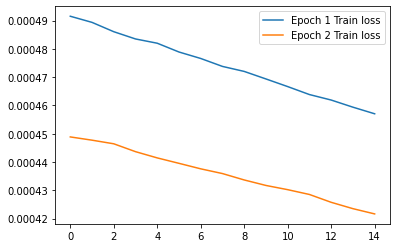

In [ ]:
# loss_tr1 = [l for i, l in enumerate(trainer.state.iter_history["L1Loss"]) if i%2==0]
# loss_tr2 = [l for i, l in enumerate(trainer.state.iter_history["L1Loss"]) if i%2!=0]

# plt.plot(loss_tr1, label = "Epoch 1 Train loss");
# plt.plot(loss_tr2, label = "Epoch 2 Train loss");
# plt.legend();
# #plt.plot(trainer.state.past_iter_history["L1Loss"]);



---



## **Testing Mask Inference Model: Separation and Evaluation**

### **Separation**

Once the model has been trained, let's test how good is the separation it performs.

For greater efficiency in testing the models, a selection box has been implemented, so that the hyperparameters of the model can be chosen quickly.

In [76]:
#@title **Choose hyperparameters**

Target_instrument = 'Violin' #@param ["Violin", "Bassoon", "Clarinet", "Saxphone"]
Max_mixtures = "10" #@param [1, 10]
Hidden_size = "200" #@param [50, 100, 200]
Num_layers = "2" #@param [1, 2]
Dropout = "0.2" #@param [0, 0.2, 0.3]
Epoch_length = "25" #@param [10, 25, 30]
Max_epochs = "3" #@param [2, 3]
Leave_song = "3" #@param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Target_instrument = Target_instrument.lower()

The choice of each hyperparameter will form the title of each trained model.

In [77]:
model_config_str = f"SepModel_{Target_instrument}_MaxMix={Max_mixtures}_HSize={Hidden_size}_NLayers={Num_layers}_Dropout={Dropout}_EpcLen={Epoch_length}_MaxEpc={Max_epochs}"
print(model_config_str)

SepModel_violin_MaxMix=10_HSize=200_NLayers=2_Dropout=0.2_EpcLen=25_MaxEpc=3


Define the separator of the chosen model.

In [78]:
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path = f'Bach10_nussl/models/leaveSong{Leave_song}/'+ model_config_str +'/checkpoints/best.model.pth',
    device=DEVICE,
)
song_output_folder = f'Bach10_nussl/models/leaveSong{Leave_song}/'+ model_config_str



---



### **Test set Evaluation**

Let's evaluate our model on our test set.

The evaluation has been divided into two parts: **objective evaluation** and **subjective evaluation**.

- ***Subjective evaluation***:



We can perform the subjective evaluation by listening to the individual pieces that the model has estimated for a given test left song.

Evaluate and visualize the estimates sources:

In [80]:
# Generates something like: bassoon+clarinet+saxphone
concat_instr_str = '+'.join(sum_sources[Target_instrument][0])

tfm = nussl_tfm.Compose([nussl_tfm.SumSources(sum_sources[Target_instrument]),])

test_folder = f'Bach10_nussl/Bach10_nussl_leaveSong{Leave_song}/test'
test_dataset = hooks.MixSourceFolder(folder=test_folder, transform=tfm, stft_params=stft_params)

print(f"Evaluating {Target_instrument} separator vs {concat_instr_str}.")
item = test_dataset[0]
print(item["mix"].path_to_input_file)
separator.audio_signal = item['mix']
estimates = separator()

source_keys = list(item['sources'].keys())
estimates_aux = {
    Target_instrument: estimates[0],
    concat_instr_str: item['mix'] - estimates[0]
}

viz.show_sources(estimates_aux)

sources = [item['sources'][k] for k in source_keys]
estimates = [estimates_aux[k] for k in source_keys]

evaluator = nussl.evaluation.BSSEvalScale(
    sources, estimates, source_labels=source_keys
)

scores = evaluator.evaluate()
song_output_folder = Path(song_output_folder).absolute()
song_output_folder.mkdir(exist_ok=True)

# output_file = output_folder / f"song_{i}.json"
output_file = song_output_folder / sources[0].file_name.replace('wav', 'json')

with open(output_file, 'w') as f:
    json.dump(scores, f, indent=4)

Output hidden; open in https://colab.research.google.com to view.

Now, we can compare the original separated source vs the rest:

In [81]:
true_song_sources = test_dataset[0]['sources']
viz.show_sources(true_song_sources)

Output hidden; open in https://colab.research.google.com to view.

- ***Objective Evaluation***:

To perform an objective evaluation of the separation performed by the model, we have relied on objective evaluation metrics. Among the most outstanding ones we find:

- **SI-SDR**: Scale-invariant source-to-distortion ratio. Higher is better.
- **SI-SIR**: Scale-invariant source-to-interference ratio. Higher is better.
- **SI-SAR**: Scale-invariant source-to-artifact ratio. Higher is better.
- **SNR**: Signal-to-noise ratio. Higher is better.

The evaluate above iterates over items in the test dataset and calculates a lot of metrics for each one. These metrics are saved to JSON files whose name is the same as the name of the item’s filename. We can aggregate all of the metrics into a single report card using nussl.

Let's see the report card:

In [82]:
json_files = glob.glob(f'Bach10_nussl/models/leaveSong{Leave_song}/'+ model_config_str +"/*.json")

df = nussl.evaluation.aggregate_score_files(
    json_files, aggregator=np.nanmedian)
nussl.evaluation.associate_metrics(separator.model, df, test_dataset)
report_card = nussl.evaluation.report_card(df, report_each_source=True)
print(report_card)

                                                                                
                             MEAN +/- STD OF METRICS                              
                                                                                
┌────────────┬──────────────────┬────────────────────────────┬──────────────────┐
│ METRIC     │     OVERALL      │ BASSOON+CLARINET+SAXPHONE  │      VIOLIN      │
╞════════════╪══════════════════╪════════════════════════════╪══════════════════╡
│ #          │        2         │             1              │        1         │
├────────────┼──────────────────┼────────────────────────────┼──────────────────┤
│ MIX-SD-SDR │  -0.06 +/-  6.75 │        4.70 +/-   nan      │  -4.84 +/-   nan │
├────────────┼──────────────────┼────────────────────────────┼──────────────────┤
│ MIX-SI-SDR │  -0.06 +/-  6.75 │        4.70 +/-   nan      │  -4.84 +/-   nan │
├────────────┼──────────────────┼────────────────────────────┼──────────────────┤
│ MIX-SNR    │   



---



### **Automation of the testing step for all LeaveOneOut pieces and instruments**
Now let's automate the testing step for all LeaveOneOut pieces and instruments, for a given model configuration:

In [29]:
modelA = {'Max_mixtures': 10, 'Hidden_size': 50, 'Num_layers': 1, 'Dropout': 0, 'Epoch_length': 10, 'Max_epochs': 1}
modelB = {'Max_mixtures': 10, 'Hidden_size': 50, 'Num_layers': 2, 'Dropout': 0.2, 'Epoch_length': 10, 'Max_epochs': 1}
modelC = {'Max_mixtures': 10, 'Hidden_size': 100, 'Num_layers': 2, 'Dropout': 0.2, 'Epoch_length': 10, 'Max_epochs': 1}
modelD = {'Max_mixtures': 10, 'Hidden_size': 100, 'Num_layers': 2, 'Dropout': 0.2 , 'Epoch_length': 25, 'Max_epochs': 3}
modelE = {'Max_mixtures': 10, 'Hidden_size': 200, 'Num_layers': 2, 'Dropout': 0.2, 'Epoch_length': 25, 'Max_epochs': 3}
modelF = {'Max_mixtures': 1, 'Hidden_size': 200, 'Num_layers': 2, 'Dropout': 0.2, 'Epoch_length': 25, 'Max_epochs': 3}

model_configs = [modelA, modelB, modelC, modelD, modelE, modelF]

In [13]:
# Storing csvs here for record keeping...
!mkdir Bach10_nussl/ModelResults

mkdir: cannot create directory ‘Bach10_nussl/ModelResults’: File exists


In [31]:
for model in model_configs:

  Max_mixtures = str(model['Max_mixtures'])
  Hidden_size = str(model['Hidden_size'])
  Num_layers = str(model['Num_layers'])
  Dropout = str(model['Dropout'])
  Epoch_length = str(model['Epoch_length'])
  Max_epochs = str(model['Max_epochs'])

  print(f"----> MODEL TO EVALUATE: MaxMix={Max_mixtures}_HSize={Hidden_size}_NLayers={Num_layers}_Dropout={Dropout}_EpcLen={Epoch_length}_MaxEpc={Max_epochs}")
  all_instr_stats_df = pd.DataFrame(columns=['Target_instrument', 
                                            'Avg+-Std SI-SAR', 'Avg+-Std SI-SDR', 'Avg+-Std SI-SIR', 'Avg+-Std SNR'])

  desired_metrics = ['SI-SAR', 'SI-SDR', 'SI-SIR', 'SNR']

  for Target_instrument in instruments:
    print(f"= Evaluating model for {Target_instrument} separation...")

    final_df = pd.DataFrame(columns=['file']+desired_metrics)

    for Leave_song in songs:

      model_config_str = f"SepModel_{Target_instrument}_MaxMix={Max_mixtures}_HSize={Hidden_size}_NLayers={Num_layers}_Dropout={Dropout}_EpcLen={Epoch_length}_MaxEpc={Max_epochs}"

      # Define the separator of the chosen model
      separator = nussl.separation.deep.DeepMaskEstimation(
        nussl.AudioSignal(), model_path = f'Bach10_nussl/models/leaveSong{Leave_song}/'+ model_config_str +'/checkpoints/best.model.pth',
        device=DEVICE,
      )

      concat_instr_str = '+'.join(sum_sources[Target_instrument][0])

      tfm = nussl_tfm.Compose([nussl_tfm.SumSources(sum_sources[Target_instrument]),])

      test_folder = f'Bach10_nussl/Bach10_nussl_leaveSong{Leave_song}/test'
      test_dataset = hooks.MixSourceFolder(folder=test_folder, transform=tfm, stft_params=stft_params)

      item = test_dataset[0]

      separator.audio_signal = item['mix']
      estimates = separator()

      source_keys = list(item['sources'].keys())
      estimates_aux = {
          Target_instrument: estimates[0],
          concat_instr_str: item['mix'] - estimates[0]
      }

      sources = [item['sources'][k] for k in source_keys]
      estimates = [estimates_aux[k] for k in source_keys]

      evaluator = nussl.evaluation.BSSEvalScale(
          sources, estimates, source_labels=source_keys
      )

      scores = evaluator.evaluate()
      song_output_folder = f'Bach10_nussl/models/leaveSong{Leave_song}/'+ model_config_str
      song_output_folder = Path(song_output_folder).absolute()
      song_output_folder.mkdir(exist_ok=True)

      output_file = song_output_folder / sources[0].file_name.replace('wav', 'json')

      with open(output_file, 'w') as f:
          json.dump(scores, f, indent=4)

      json_files = glob.glob(f'Bach10_nussl/models/leaveSong{Leave_song}/'+ model_config_str +"/*.json")

      df = nussl.evaluation.aggregate_score_files(json_files, aggregator=np.nanmedian)

      final_df = final_df.append(pd.DataFrame(df.iloc[0]).T[['file']+desired_metrics])
      #report_card = nussl.evaluation.report_card(df, report_each_source=True)

    instr_stats_df = pd.DataFrame(final_df[desired_metrics].mean(), columns=['Mean'])
    instr_stats_df['Std'] = pd.DataFrame(final_df[desired_metrics].std(), columns=['Std'])['Std']
    instr_stats_df['avg ± std'] = instr_stats_df.apply(lambda row: str(round(row.Mean,4))+ " ± " +str(round(row.Std,4)), axis = 1)

    print(instr_stats_df)

    instr_df = pd.DataFrame(columns=['Target_instrument','Avg+-Std SI-SAR', 'Avg+-Std SI-SDR', 'Avg+-Std SI-SIR', 'Avg+-Std SNR'])
    df_metrics = instr_stats_df['avg ± std'].values

    instr_df = instr_df.append({'Target_instrument':Target_instrument,
                              'Avg+-Std SI-SAR': df_metrics[0], 
                              'Avg+-Std SI-SDR': df_metrics[1], 
                              'Avg+-Std SI-SIR': df_metrics[2], 
                              'Avg+-Std SNR': df_metrics[3]}
                              , ignore_index=True)
    all_instr_stats_df = all_instr_stats_df.append(instr_df)

  fname = "Bach10_nussl/ModelResults/SepModel_"+"_".join(model_config_str.split("_")[2:])+"_FULL_EVAL_RESULTS.csv"
  all_instr_stats_df.to_csv(fname)
  print("Saved full evaluation csv to: ", fname)

----> MODEL TO EVALUATE: MaxMix=10_HSize=50_NLayers=1_Dropout=0_EpcLen=10_MaxEpc=1
= Evaluating model for violin separation...
            Mean       Std         avg ± std
SI-SAR  7.815584  1.592158   7.8156 ± 1.5922
SI-SDR -3.942638  0.599253  -3.9426 ± 0.5993
SI-SIR -3.621085  0.672604  -3.6211 ± 0.6726
SNR     1.050704  0.336293   1.0507 ± 0.3363
= Evaluating model for bassoon separation...
            Mean       Std         avg ± std
SI-SAR  7.378888  1.521580   7.3789 ± 1.5216
SI-SDR -5.707050  0.562657  -5.7071 ± 0.5627
SI-SIR -5.472732  0.600843  -5.4727 ± 0.6008
SNR     0.207290  0.227795   0.2073 ± 0.2278
= Evaluating model for clarinet separation...
            Mean       Std         avg ± std
SI-SAR  8.635595  1.338031    8.6356 ± 1.338
SI-SDR -4.510736  0.502591  -4.5107 ± 0.5026
SI-SIR -4.284232  0.520138  -4.2842 ± 0.5201
SNR     0.467731  0.276146   0.4677 ± 0.2761
= Evaluating model for saxphone separation...
            Mean       Std         avg ± std
SI-SAR  7.399553

We can check how our stats dataframe (for a particular model configuration) looks like:

In [32]:
all_instr_stats_df

,Target_instrument,Avg+-Std SI-SAR,Avg+-Std SI-SDR,Avg+-Std SI-SIR,Avg+-Std SNR
0,violin,-3.3146 ± 2.0966,-4.4473 ± 2.0246,2.4107 ± 2.6533,1.1831 ± 0.5565
0,bassoon,6.2579 ± 1.4525,-6.1195 ± 0.4126,-5.8491 ± 0.3964,-2.956 ± 0.3487
0,clarinet,-0.494 ± 2.4938,-4.4095 ± 2.3615,-2.1163 ± 2.3298,1.0546 ± 0.7013
0,saxphone,0.6471 ± 0.5264,-3.7682 ± 0.6311,-1.7807 ± 0.9112,0.9574 ± 0.3135


We can now obtain the final result tables!



---



### **Overall results - Comparison of models (for each instrument)**
After training all models, it is possible to display in a table the overall results for each different model training configuration.

Metrics: mean of the leave-one-out experiments together with their corresponding standard deviations.

In [43]:
df_modelA = pd.read_csv('Bach10_nussl/ModelResults/SepModel_MaxMix=10_HSize=50_NLayers=1_Dropout=0_EpcLen=10_MaxEpc=1_FULL_EVAL_RESULTS.csv')
df_modelB = pd.read_csv('Bach10_nussl/ModelResults/SepModel_MaxMix=10_HSize=50_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1_FULL_EVAL_RESULTS.csv')
df_modelC = pd.read_csv('Bach10_nussl/ModelResults/SepModel_MaxMix=10_HSize=100_NLayers=2_Dropout=0.2_EpcLen=10_MaxEpc=1_FULL_EVAL_RESULTS.csv')
df_modelD = pd.read_csv('Bach10_nussl/ModelResults/SepModel_MaxMix=10_HSize=100_NLayers=2_Dropout=0.2_EpcLen=25_MaxEpc=3_FULL_EVAL_RESULTS.csv')
df_modelE = pd.read_csv('Bach10_nussl/ModelResults/SepModel_MaxMix=10_HSize=200_NLayers=2_Dropout=0.2_EpcLen=25_MaxEpc=3_FULL_EVAL_RESULTS.csv')
df_modelF = pd.read_csv('Bach10_nussl/ModelResults/SepModel_MaxMix=1_HSize=200_NLayers=2_Dropout=0.2_EpcLen=25_MaxEpc=3_FULL_EVAL_RESULTS.csv')

models = [df_modelA, df_modelB, df_modelC, df_modelD, df_modelE, df_modelF]
model_name = ['Model A', 'Model B', 'Model C', 'Model D', 'Model E', 'Model F']

In [73]:
for f, instrument in enumerate(instruments):
  all_models_stats_df = pd.DataFrame(columns=['Models','Avg+-Std SI-SAR', 'Avg+-Std SI-SDR', 'Avg+-Std SI-SIR', 'Avg+-Std SNR'])  
  for i, df_model in enumerate(models):
    models_df = pd.DataFrame(columns=['Models','Avg+-Std SI-SAR', 'Avg+-Std SI-SDR', 'Avg+-Std SI-SIR', 'Avg+-Std SNR'])
    models_df = models_df.append({'Models': model_name[i],
                                  'Avg+-Std SI-SAR': df_model.loc[f, 'Avg+-Std SI-SAR'], 
                                  'Avg+-Std SI-SDR': df_model.loc[f, 'Avg+-Std SI-SDR'], 
                                  'Avg+-Std SI-SIR': df_model.loc[f, 'Avg+-Std SI-SIR'], 
                                  'Avg+-Std SNR': df_model.loc[f, 'Avg+-Std SNR']}
                                  , ignore_index=True)
    
    all_models_stats_df = all_models_stats_df.append(models_df)

  fname = f"Bach10_nussl/ModelResults/SepModel_{instrument}_FULL_EVAL_RESULTS.csv"
  all_models_stats_df.to_csv(fname)
  print("Saved full evaluation csv to: ", fname)

Saved full evaluation csv to:  Bach10_nussl/ModelResults/SepModel_violin_FULL_EVAL_RESULTS.csv
Saved full evaluation csv to:  Bach10_nussl/ModelResults/SepModel_bassoon_FULL_EVAL_RESULTS.csv
Saved full evaluation csv to:  Bach10_nussl/ModelResults/SepModel_clarinet_FULL_EVAL_RESULTS.csv
Saved full evaluation csv to:  Bach10_nussl/ModelResults/SepModel_saxphone_FULL_EVAL_RESULTS.csv


We can check how our stats dataframe (for a particular instrument) looks like:

In [74]:
all_models_stats_df

,Models,Avg+-Std SI-SAR,Avg+-Std SI-SDR,Avg+-Std SI-SIR,Avg+-Std SNR
0,Model A,7.3996 ± 1.4156,-5.463 ± 0.4938,-5.2234 ± 0.4942,0.2337 ± 0.1872
0,Model B,6.3174 ± 1.3455,-5.3702 ± 0.4917,-5.0489 ± 0.5288,0.4234 ± 0.2309
0,Model C,3.9302 ± 2.627,-5.1329 ± 0.631,-4.4158 ± 0.9367,0.517 ± 0.3402
0,Model D,3.7486 ± 1.4644,-2.5352 ± 0.9446,-1.2783 ± 1.2381,1.5628 ± 0.4537
0,Model E,4.0214 ± 0.622,-2.179 ± 0.7487,-0.9612 ± 0.9328,1.7026 ± 0.2956
0,Model F,0.6471 ± 0.5264,-3.7682 ± 0.6311,-1.7807 ± 0.9112,0.9574 ± 0.3135




---



## **Try evaluating on your own audio mix**

An option has been implemented to upload your own musical mix and listen the estimated separation by yourself.

> **Note**: The audio mix must be in *.wav* format, and contain at least one of the instruments that has been trained for separating, which are: Violin, Bassoon, Clarinet or Saxophone.

> **Note 2**: For the user evaluation, only the subjective evaluation method is available.

Evaluate the separation from an upload file:

**WARNING: *.WAV* FILES HEAVIER THAN 3MB MAY NOT BE SHOWN OR PRODUCE ERRORS IN THE VISUALIZATION-LISTENING SCRIPT**

In [20]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving custom_song_compressed.wav to custom_song_compressed.wav
User uploaded file "custom_song_compressed.wav" with length 2998238 bytes


In [21]:
!ls

 Bach10		 Bach10_spleeter	     'Other Datasets'
 Bach10_nussl	 cache			      pretrained_models
 Bach10_Scaper	 custom_song_compressed.wav


In [22]:
import shlex
# to escape bash caracters

wav_filename = shlex.quote([name for name in uploaded.keys()][0])
print(wav_filename)

# File may need to be resampled
import librosa, soundfile
y, sr = librosa.load(wav_filename, sr=44100)

soundfile.write(wav_filename, y, sr)

custom_song_compressed.wav


In [23]:
custom_test_path = "Bach10_nussl/custom_test/mix"
if not os.path.exists(custom_test_path):
        os.makedirs(custom_test_path)
        print("Directory " , custom_test_path ,  " Created ")

!mv $wav_filename $custom_test_path

Directory  Bach10_nussl/custom_test/mix  Created 


In [24]:
!ls Bach10_nussl/custom_test/mix

custom_song_compressed.wav


I know this is weird, but the implementation authors have required the code to simulate a fixed structure, even if our custom mix does not have the rest of these instruments... Just execute this, trust me :)

In [25]:
!mkdir Bach10_nussl/custom_test/violin
!mkdir Bach10_nussl/custom_test/bassoon
!mkdir Bach10_nussl/custom_test/clarinet
!mkdir Bach10_nussl/custom_test/saxphone

In [26]:
!cp Bach10_nussl/custom_test/mix/* Bach10_nussl/custom_test/violin/
!cp Bach10_nussl/custom_test/mix/* Bach10_nussl/custom_test/clarinet/
!cp Bach10_nussl/custom_test/mix/* Bach10_nussl/custom_test/saxphone/
!cp Bach10_nussl/custom_test/mix/* Bach10_nussl/custom_test/bassoon/

In [27]:
#@title **Choose the instrument you want to separate**

instrument = 'Violin' #@param ["Violin", "Bassoon", "Clarinet", "Saxphone"]
instrument = instrument.lower()

Now we are ready to (finally) see the results on our custom .wav file!

> **Note**: Ignore plot labels, they show the default instruments the model has been trained off.

In [28]:
# Reproduce and visualize
concat_instr_str = '+'.join(sum_sources[instrument][0])

tfm = nussl_tfm.Compose([nussl_tfm.SumSources(sum_sources[instrument]),])

custom_test_folder = 'Bach10_nussl/custom_test'
custom_dataset = hooks.MixSourceFolder(folder=custom_test_folder, transform=tfm, stft_params=stft_params)

print(f"Evaluating {instrument} separator vs others.")

item = custom_dataset[0]

separator.audio_signal = item['mix']

estimates = separator()

estimates_aux = {
    instrument: estimates[0],
    concat_instr_str: item['mix'] - estimates[0]
}

viz.show_sources(estimates_aux)

Output hidden; open in https://colab.research.google.com to view.